# Train character embeddings using word2vec skipgram approach 

We look at ith character and try to predict (i-1) and (i+1) character

In [1]:
#for inline plotting in notebooks
%matplotlib inline  

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get data

In [4]:
# load data
path = "./../data/harry_potter_3.txt"
text = open(path).read()

corpus_length = len(text)

print('corpus length:', corpus_length)

corpus length: 611606


In [5]:
unique_chars = list(set(text))
print('total no of unique chars:', len(unique_chars))

print ("\nSet of characters : \n" + str(unique_chars))

total no of unique chars: 79

Set of characters : 
['(', 'C', '`', 'M', 'N', ':', 'X', 'x', 'Y', 'B', ')', 'S', '!', '*', 'k', 't', '"', 'U', ';', 'g', 'I', '5', 'L', '2', 'd', 'b', '1', '\n', ' ', 'z', 'n', 'J', '3', "'", 'm', 'E', 'l', '9', 'H', 'Q', 'F', '4', 'K', '&', 'A', '-', '?', '\\', 'O', 'f', 'V', 'D', 'y', 'P', '7', '6', 'p', 'w', 'i', 'q', 'G', 'v', 'c', '0', '_', 'u', 'r', 'h', 'T', 'W', 's', 'a', 'o', 'R', ',', 'e', '.', 'Z', 'j']


In [6]:
def classToOneHot(item, classes):

	x = [0. for _ in classes]
	
	x[classes.index(item)] = 1.

	return x

In [7]:
classToOneHot('a', unique_chars)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [8]:
def findClosest(labels, coords, n=3):
	def dist(p1, p2):
		return np.linalg.norm(np.array(p1)-np.array(p2))
	for label, pos in zip(labels, coords):
		print(label)
		dists = []
		for l2, p2 in zip(labels, coords):
			if l2==label: continue
			dists.append((l2, dist(pos, p2)))
		dists = sorted(dists, key=lambda x : x[1])
		if n == -1:
			if dists[0][1] >= 0.2:
				print("\t{}\t{}".format(dists[0][0], dists[0][1]))
			else:
				for d in dists:
					if d[1] <= 0.15:
						print("\t{}\t{}".format(d[0], d[1]))
		else:		
			for d in dists[:n]:
				print("\t{}\t{}".format(d[0], d[1]))

In [33]:
# prepare training data X, y
# both X,y are are characters 

skip_window = 1 # how much we see on either side of center word
global_index = skip_window # 

X = []
y = []

for i in range(global_index, (corpus_length - skip_window)):

    #print i
    
    X_char = text[i]
    y1_char = text[i-1]
    y2_char = text[i+1]
    
    #print X_char
    #print y1_char, y2_char
    X.append(classToOneHot(X_char, unique_chars))
    yp=[classToOneHot(y1_char, unique_chars), classToOneHot(y2_char, unique_chars)] 
    
    y.append(yp)
    
X=np.array(X)    
    

In [34]:
print(np.shape(X), np.shape(y), (len(unique_chars),), )

(611604, 79) (611604, 2, 79) (79,)


In [35]:
nb_cols = len(y[0])
y_cols = [np.array([v[i] for v in y], np.float32) for i in range(nb_cols)]

input_layer = Input(shape=(len(unique_chars),))
encoding = Dense(2, activation='linear')(input_layer)

output_1 = Dense(len(unique_chars), activation='softmax')(encoding)
output_2 = Dense(len(unique_chars), activation='softmax')(encoding)

model = Model(inputs=[input_layer], outputs=[output_1, output_2])#, output_3, output_4])

encoder = Model(inputs = [input_layer], outputs=[encoding])

# when using larger windows, remember to add more loss weights
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', loss_weights=[0.5, 0.5])

#model.fit(X, y_cols, nb_epoch=15, batch_size=1024, shuffle=True, verbose=True)

In [36]:
model.fit(X_new, y_cols, epochs=15, batch_size=1024, shuffle=True, verbose=True)

Epoch 1/15
611604/611604 [==============================] - 5s 8us/step - loss: 3.7378 - dense_8_loss: 3.7429 - dense_9_loss: 3.7328
Epoch 2/15
611604/611604 [==============================] - 5s 8us/step - loss: 3.1516 - dense_8_loss: 3.1547 - dense_9_loss: 3.1485
Epoch 3/15
611604/611604 [==============================] - 5s 8us/step - loss: 3.0317 - dense_8_loss: 3.0391 - dense_9_loss: 3.0243
Epoch 4/15
611604/611604 [==============================] - 5s 8us/step - loss: 2.9670 - dense_8_loss: 2.9832 - dense_9_loss: 2.9508
Epoch 5/15
611604/611604 [==============================] - 5s 8us/step - loss: 2.9324 - dense_8_loss: 2.9501 - dense_9_loss: 2.9147
Epoch 6/15
611604/611604 [==============================] - 5s 8us/step - loss: 2.9122 - dense_8_loss: 2.9264 - dense_9_loss: 2.8980
Epoch 7/15
611604/611604 [==============================] - 5s 8us/step - loss: 2.9006 - dense_8_loss: 2.9103 - dense_9_loss: 2.8908
Epoch 8/15
611604/611604 [==============================] - 5s 8us/st

In [37]:
x2 = [classToOneHot(ch, unique_chars) for ch in unique_chars[:-1]]
encodings = encoder.predict(np.array(x2))
for ch, e in zip(unique_chars[:-1], encodings):
    print("{}\t{}\t{}".format(ch, e[0], e[1]))

(	-0.4189308285713196	-1.4592013359069824
C	-0.30931633710861206	-2.3553853034973145
`	-0.7693307995796204	-0.5980441570281982
M	-0.7547428011894226	-2.987598419189453
N	-0.013801217079162598	-2.4258015155792236
:	-0.6471530199050903	-1.4153797626495361
X	-0.3677148222923279	-0.42123231291770935
x	-1.3780877590179443	-0.7946587800979614
Y	-0.2278653085231781	-3.4786460399627686
B	-0.5086053013801575	-2.469062328338623
)	-0.7490473389625549	-1.3739827871322632
S	-0.44035619497299194	-1.8497459888458252
!	0.33463913202285767	-1.8535802364349365
*	-0.23555347323417664	-0.5445050001144409
k	-3.000659942626953	-1.008245587348938
t	-1.828667402267456	-1.9932234287261963
"	1.1655738353729248	-2.4635119438171387
U	0.12202352285385132	-0.3550833761692047
;	-0.9099583625793457	-1.0440223217010498
g	-2.2557122707366943	-1.458530306816101
I	-0.3056845963001251	-1.7479033470153809
5	-0.3904525637626648	-0.4832148551940918
L	-0.4394199550151825	-2.560626268386841
2	-0.5540075898170471	-0.52219921350

(
	:	0.23239126801490784
	I	0.3101186156272888
C
	B	0.2294309437274933
	L	0.243003711104393
`
	&	0.15880447626113892
	_	0.16607674956321716
M
	R	0.14439500868320465
	D	0.40041476488113403
N
	C	0.30378878116607666
	-	0.43486350774765015
:
	)	0.10998255014419556
	(	0.23239126801490784
X
	5	0.06602150946855545
	*	0.1807284653186798
x
	;	0.5304029583930969
	_	0.6344789862632751
Y
	T	0.3395034968852997
	R	0.7171933650970459
B
	L	0.11476308852434158
	F	0.16861547529697418
)
	:	0.10998255014419556
	,	0.3101251721382141
S
	I	0.16884419322013855
	(	0.3911319077014923
!
	?	0.26218175888061523
	.	0.42643219232559204
*
	\	0.1320345103740692
	1	0.14770597219467163
k
	d	0.2855704128742218
	l	0.34450027346611023
t
	c	0.3146638572216034
	b	0.42687636613845825
"
	
	0.5176706314086914
	-	0.745117723941803
U
	1	0.264723002910614
	E	0.3381451666355133
;
	0	0.29608726501464844
	_	0.32679641246795654
g
	s	0.05534025654196739
	f	0.09808792918920517
I
	S	0.16884419322013855
	(	0.3101186156272888
5
	X	0.066021

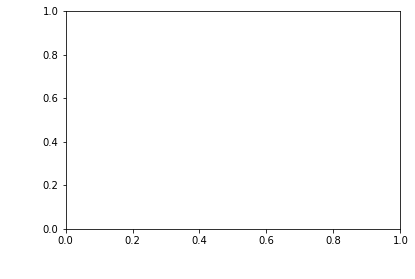

In [38]:
labels = unique_chars[:-1]
xd = [e[0] for e in encodings]
yd = [e[1] for e in encodings]
fig, ax = plt.subplots()
for i, txt in enumerate(labels):
    _ = ax.annotate(txt, (xd[i],yd[i]))


findClosest(labels, encodings, n=2)

plt.show()